In [50]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import Compose

from synthetic_data.mlops.datasets.multiharmonic import MultiHarmonicDataset
from synthetic_data.mlops.models.cgan import Generator
from synthetic_data.mlops.tools import analysis
from synthetic_data.mlops.tools.analysis import visualization
from synthetic_data.mlops.transforms.transform import RandomRoll

In [51]:
dataset_names = [
    "Harmon 1",
    "Harmon 2",
    "Harmon 3",
    "Harmon 4",
    "Harmon 5",
    "Harmon 6",
    "Harmon 7",
    "Harmon 8",
    "Harmon 9",
    "Harmon 10",
]

dataset_labels = {
    "1": 0,
    "2": 1,
    "3": 2,
    "4": 3,
    "5": 4,
    "6": 5,
    "7": 6,
    "8": 7,
    "9": 8,
    "10": 9,
}

transforms = Compose([RandomRoll(p=-1.0)])

dataset = MultiHarmonicDataset(
    names=dataset_names,
    label_map=dataset_labels,
    transforms=transforms,
    save=True,
    local_dir="tmp"
)

Loaded data from tmp/MultiHarmonicDataset


In [52]:
seq_length = dataset.get_sequence_length()
n_samples = len(dataset)
# NOTE: we assume equally sized datasets
n_samples_per_dataset = int(n_samples / len(dataset_names))

params = dict(
    z_dim=100,
    n_classes=10,
    z_type="normal",
    seq_length=seq_length,
    n_samples=n_samples,
    n_samples_per_dataset=n_samples_per_dataset,
)

In [54]:
checkpoints = torch.load("../../epoch_249.pkl")
generator = Generator(params["seq_length"], params["n_classes"], params["z_dim"])
generator.load_state_dict(checkpoints["modelG"])
generator.eval()

Generator(
  (embedder): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=False)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=False)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): Tanh()
  )
)

## Original vs. Synthetic Data

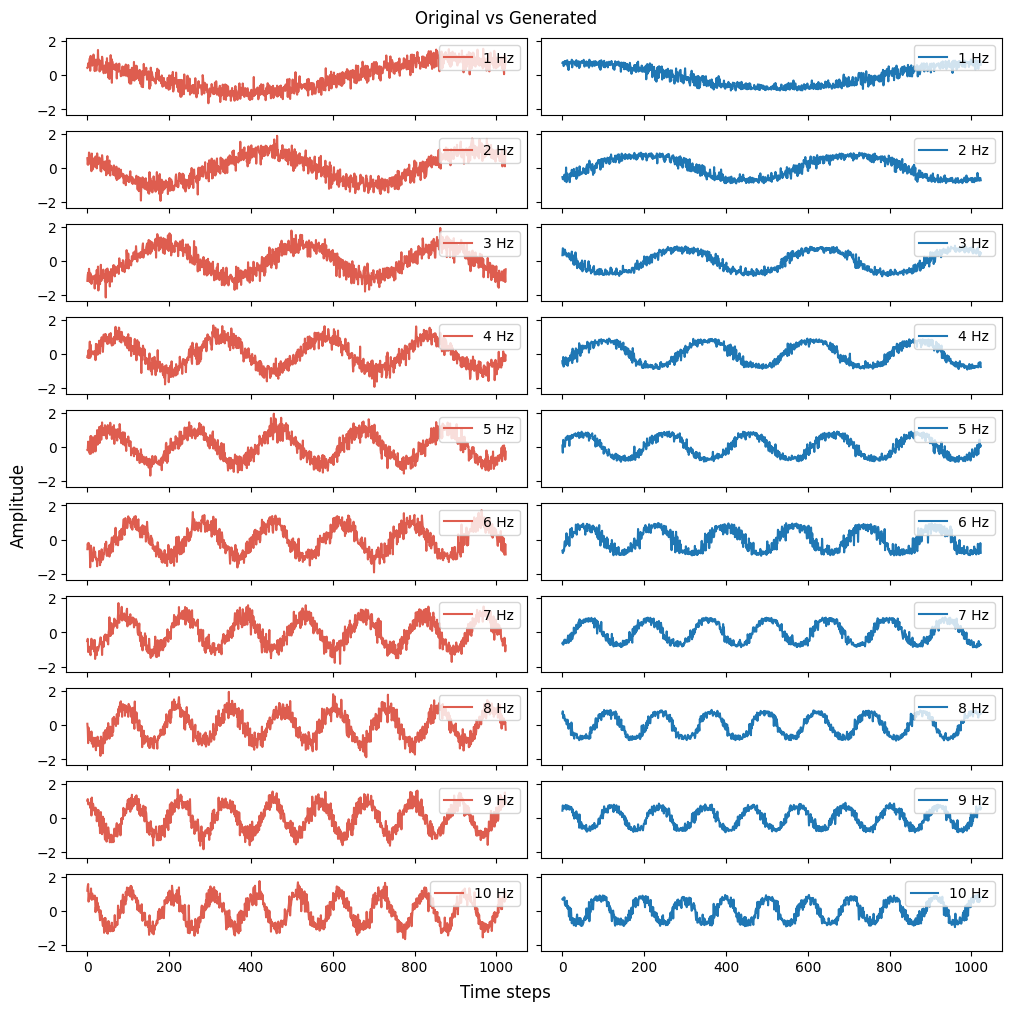

In [55]:
labels = torch.arange(params["n_classes"])
sequences = analysis.genererate_sequences(generator, labels)

fig, axis = plt.subplots(
    nrows=len(sequences),
    ncols=2,
    figsize=(10, params["n_classes"]),
    sharex=True,
    sharey=True,
    constrained_layout=True,
    dpi=100,
)
for i in range(len(sequences)):
    original_seq, _ = dataset[i*1000+500]
    axis[i, 0].plot(original_seq.detach().numpy(), label=f"{i+1} Hz", color="#DE5D4F")
    axis[i, 0].legend(loc="upper right")
    axis[i, 1].plot(sequences[i].detach().numpy(), label=f"{i+1} Hz")
    axis[i, 1].legend(loc="upper right")
fig.suptitle("Original vs Generated")
fig.supxlabel("Time steps")
fig.supylabel("Amplitude")
plt.show()

## Generate data, extract featuers and view Average cosine similarity

In [56]:
ordered_labels = analysis.generate_labels(n_samples=params["n_samples"], n_samples_per_dataset=params["n_samples_per_dataset"], n_classes=params["n_classes"])

# NOTE: We extract the dataset orderly from 1-10 Hz when using Conditional GAN
# if not using any condition, we can't use the average cosine similarity per class, just one for all
extracted_data = analysis.extract_sequences(dataset)
generated_data = analysis.genererate_sequences(generator, ordered_labels)

feature_extracted_data = analysis.sequences_to_features(extracted_data)
feature_generated_data = analysis.sequences_to_features(generated_data)

for i in range(params["n_classes"]):
    feat_1_A, feat_1_B = analysis.sample_datasets(index=i, data1=feature_extracted_data, data2=feature_generated_data)
    avg_cossim = analysis.avg_cos_sim(feat_1_A, feat_1_B)
    print(f"Average cosine similarity for class {i+1} Hz = {avg_cossim:.4f}")

Average cosine similarity for class 1 Hz = 0.9825
Average cosine similarity for class 2 Hz = 0.9792
Average cosine similarity for class 3 Hz = 0.9832
Average cosine similarity for class 4 Hz = 0.9818
Average cosine similarity for class 5 Hz = 0.9827
Average cosine similarity for class 6 Hz = 0.9832
Average cosine similarity for class 7 Hz = 0.9855
Average cosine similarity for class 8 Hz = 0.9818
Average cosine similarity for class 9 Hz = 0.9795
Average cosine similarity for class 10 Hz = 0.9798


### Ordered datasets (from 1-10)


/home/andy/dev/synthetic-data/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/andy/dev/synthetic-data/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.274s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.670975
[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.209869
[t-SNE] KL divergence after 300 iterations: 2.904109


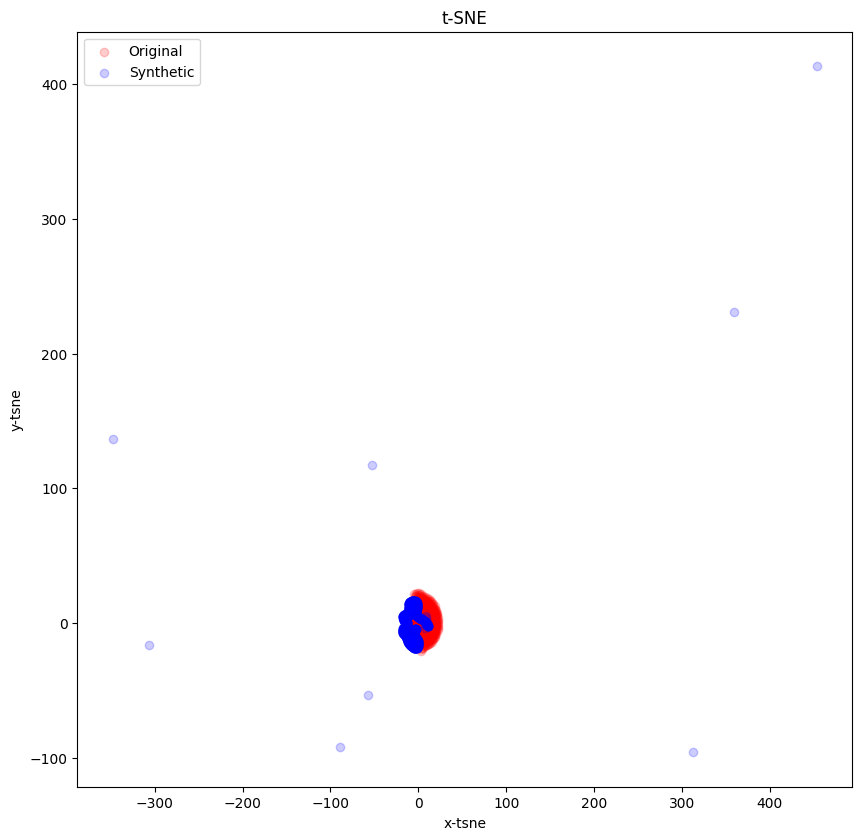

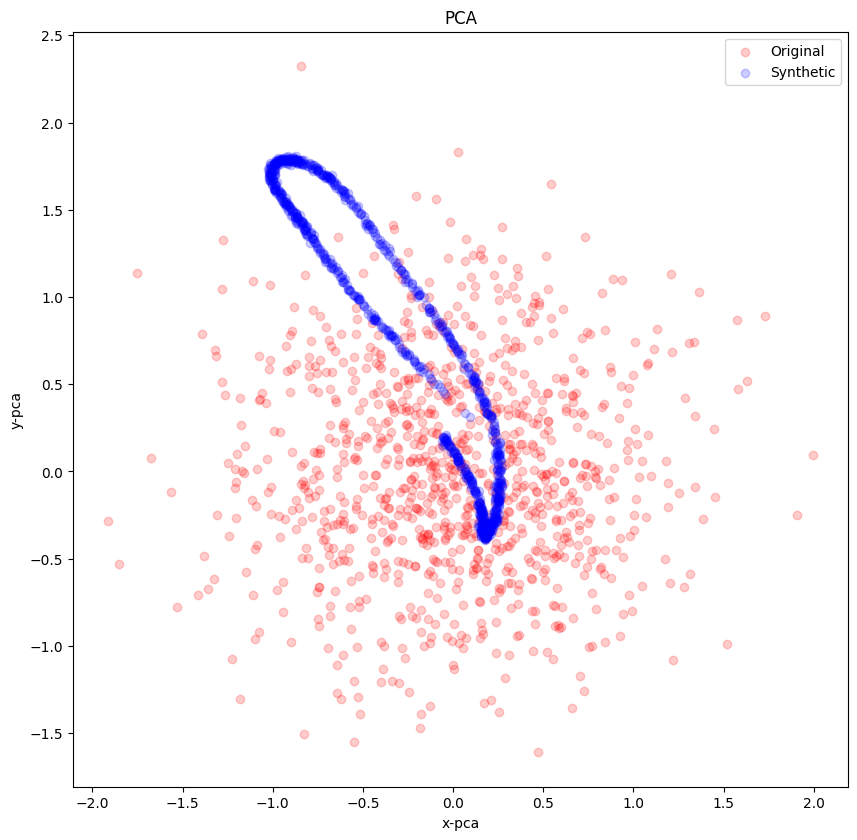

In [64]:
SAMPLE_SIZE = 1 # in percent
CLASS = 0 # 1 Hz
shuffle = False

ds1, ds2 = analysis.sample_datasets(index=CLASS, data1=extracted_data, data2=generated_data)

assert len(ds1) == len(ds2), "Datasets must have the same length"

if shuffle:
    indices = torch.randperm(ds1.shape[0])
    ds1 = ds1[indices]
    ds2 = ds2[indices]

ds1 = ds1.unsqueeze(2).detach()
ds2 = ds2.unsqueeze(2).detach()

visualization(ds1, ds2, "tsne", percent=SAMPLE_SIZE)
visualization(ds1, ds2, "pca", percent=SAMPLE_SIZE)

### Shuffled datasets

/home/andy/dev/synthetic-data/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/andy/dev/synthetic-data/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.013s...
[t-SNE] Computed neighbors for 20000 samples in 23.373s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for s

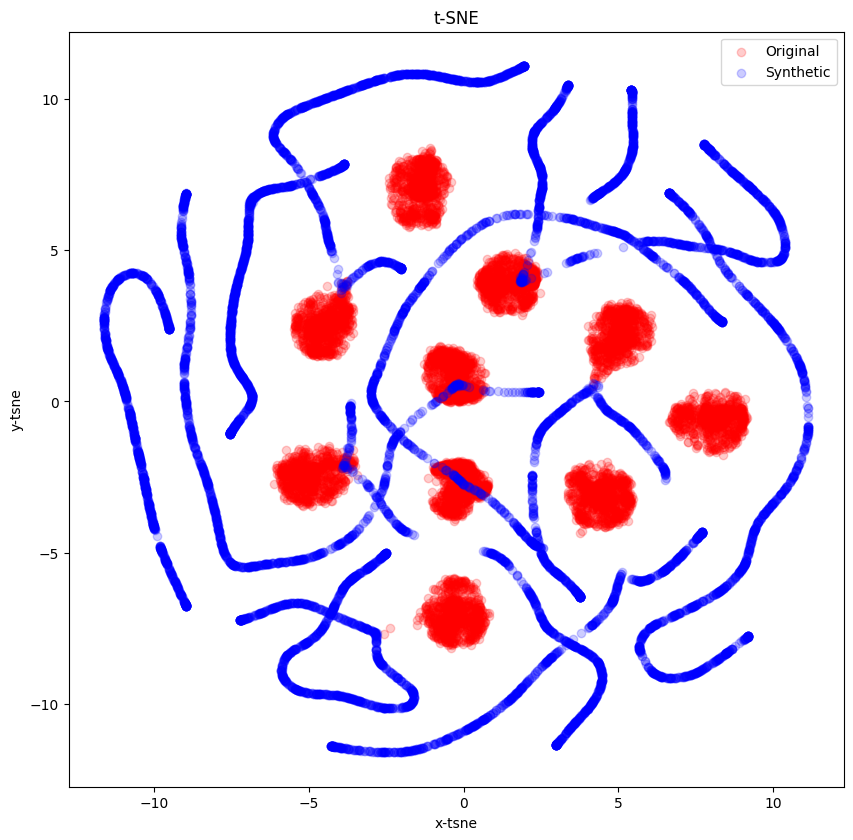

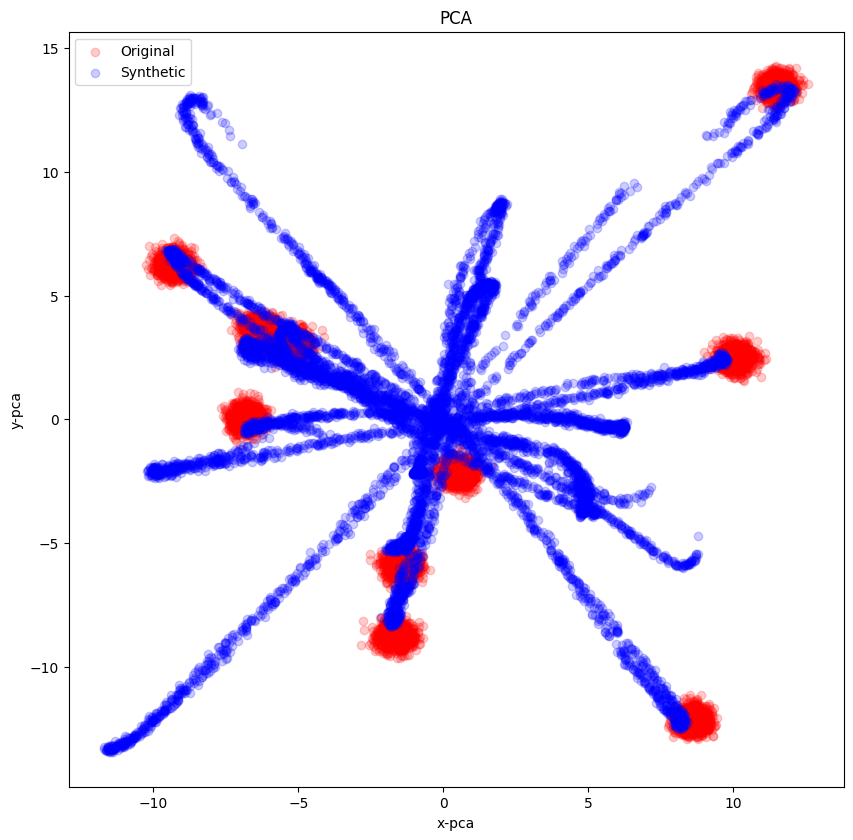

In [13]:
indices = torch.randperm(extracted_data.shape[0])

s1 = extracted_data[indices]
s2 = generated_data[indices]

s1 = s1.unsqueeze(2).detach()
s2 = s2.unsqueeze(2).detach()

visualization(s1, s2, "tsne", percent=SAMPLE_SIZE)
visualization(s1, s2, "pca", percent=SAMPLE_SIZE)